In [8]:
import yaml,sys,sqlite3,glob,pickle

import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas(leave=True)

import matplotlib.pyplot as plt
from matplotlib.patches import Arc
from matplotlib import patches

from scipy.stats import pearsonr,spearmanr

# STAT3 loci result

In [3]:
def extract_hic_matrix(HICFILE,REGION,RESOLUTION=5000):
    mzd = HICFILE.getMatrixZoomData(REGION[0], REGION[0], "observed", "NONE", "BP", RESOLUTION)
    return mzd.getRecordsAsMatrix(REGION[1], REGION[2], REGION[1], REGION[2])

def draw_arc(ax,matrix,y_offset=0,v_offset=0,v_decay=1,threshold=None,width_threshold=0,color='red'):
    # 预处理矩阵：确保对称且对角线为0
    processed_matrix = np.triu(matrix)  # 取上三角矩阵避免重复计算
    np.fill_diagonal(processed_matrix, 0)  # 对角线置0
    # 找到最大连接强度用于归一化
    max_strength = np.max(processed_matrix)

    # 6个点在一条直线上
    num_points = matrix.shape[0]
    x_positions = np.linspace(500, num_points*1000-500, num_points)
    y_positions = np.zeros(num_points)+y_offset

    # 绘制点
    #ax.scatter(x_positions, y_positions, s=100, color='blue', zorder=3)
    
    if threshold is None: threshold = 0
    else: threshold = np.quantile(processed_matrix,threshold)
    
    # 为每对点添加弧线
    for i in range(num_points):
        for j in range(i+1, num_points):  # 只计算上三角部分，避免重复
            strength = processed_matrix[i, j]
            if strength > threshold:  # 只绘制有连接的
                # 计算透明度
                alpha = (strength+v_offset) / (max_strength+v_offset) / v_decay

                # 计算中点
                center_x = (x_positions[i] + x_positions[j]) / 2
                center_y = y_offset

                # 计算弧线宽度(两点间距离)
                width = abs(x_positions[j] - x_positions[i])
                if width < width_threshold*1000:continue

                # 弧线高度与宽度比例可以调整
                height = 0.5+width/num_points/500  # 可以调整这个系数改变弧线高度

                # 创建弧线
                arc = Arc((center_x, center_y), width, height,
                         theta1=0, theta2=180,  # 半圆
                         linewidth=1.5, 
                         color=color, 
                         alpha=alpha,
                         zorder=2)

                ax.add_patch(arc)
    return ax

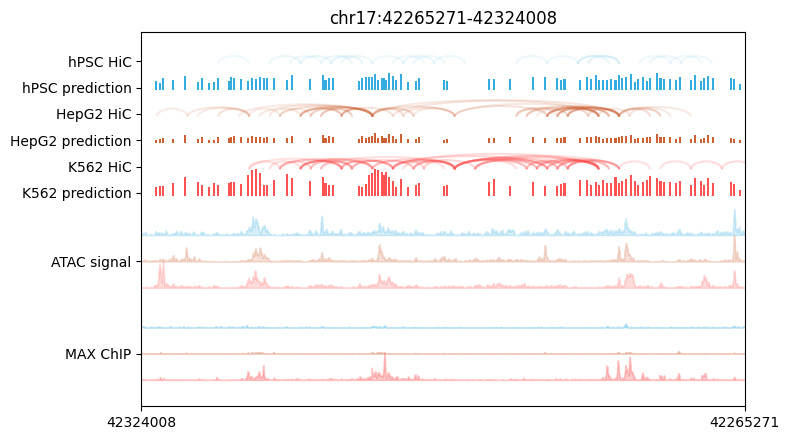

In [4]:
with open('./data/STAT3LociData.pkl','rb') as file:
    data = pickle.load(file)
    result = data['prediction'] 
    K562MAT=data['K562_HiC_Matrix'];HepG2MAT=data['HepG_HiC_Matrix'];H1MAT=data['H1_HiC_Matrix']
    K562ATAC_signal=data['K562_ATAC_Signal'];HepG2ATAC_signal=data['HepG_ATAC_Signal'];H1ATAC_signal=data['H1_ATAC_Signal']
    K562MAX_signal=data['K562_MAX_Signal'];HepG2MAX_signal=data['HepG_MAX_Signal'];H1MAX_signal=data['H1_MAX_Signal']

positions = range(0,42324008-42265271)

plt.figure(figsize=(8,4.5))

# 绘制ATAC轨道

colors = {"H1": "#34ace0", "HepG2": "#cd6133","K562": "#ff5252"}

plt.fill_between(positions, 0.5, H1ATAC_signal    / H1ATAC_signal.max()+0.5, color=colors['H1'],alpha=0.2, rasterized=True)
plt.fill_between(positions, -0.5, HepG2ATAC_signal / HepG2ATAC_signal.max()-0.5, color=colors['HepG2'],alpha=0.2, rasterized=True)
plt.fill_between(positions, -1.5, K562ATAC_signal  / K562ATAC_signal.max()-1.5, color=colors['K562'],alpha=0.2, rasterized=True)

# 根据HiC绘制弦图
ax = plt.gca()
ax = draw_arc(ax,K562MAT,y_offset=3,v_offset=0,v_decay=1.2,threshold=0.965,width_threshold=3,color=colors['K562'])
ax = draw_arc(ax,HepG2MAT,y_offset=5,v_offset=0,v_decay=1.2,threshold=0.965,width_threshold=3,color=colors['HepG2'])
ax = draw_arc(ax,H1MAT,y_offset=7,v_offset=0,v_decay=1.2,threshold=0.965,width_threshold=3,color=colors['H1'])

# 绘制ChIP-seq轨道
plt.fill_between(positions, -3, H1MAX_signal  / K562MAX_signal.max()-3, color=colors['H1'],alpha=0.3, rasterized=True)
plt.fill_between(positions, -4, HepG2MAX_signal / K562MAX_signal.max()-4, color=colors['HepG2'],alpha=0.3, rasterized=True)
plt.fill_between(positions, -5, K562MAX_signal    / K562MAX_signal.max()-5, color=colors['K562'],alpha=0.3, rasterized=True)


# 绘制预测分数
for _, cre in result.iterrows():
    rect = patches.Rectangle( (cre['start']+150-42265271,2.0),width=200,height=cre['K562_prediction']/result['K562_prediction'].max(),
                             edgecolor=None,facecolor=colors['K562'],alpha=1.0,linewidth=1.5 )
    ax.add_patch(rect)        
    rect = patches.Rectangle( (cre['start']+150-42265271,4.0),width=200,height=cre['HepG2_prediction']/result['K562_prediction'].max(),
                             edgecolor=None,facecolor=colors['HepG2'],alpha=1.0,linewidth=1.5 )
    ax.add_patch(rect)
    rect = patches.Rectangle( (cre['start']+150-42265271,6.0),width=200,height=cre['H1_prediction']/result['K562_prediction'].max(),
                             edgecolor=None,facecolor=colors['H1'],alpha=1.0,linewidth=1.5 )
    ax.add_patch(rect)

# 增加注释
plt.xticks([0,42324008-42265271],['42324008','42265271']);plt.xlim([ 0,42324008-42265271 ])
plt.yticks([7.1,6.1,5.1,4.1,3.1,2.1,-0.5,-4],
           ['hPSC HiC','hPSC prediction','HepG2 HiC','HepG2 prediction','K562 HiC','K562 prediction','ATAC signal','MAX ChIP'])
plt.ylim([-6,8.2])
plt.title(f"chr17:42265271-42324008")
plt.tight_layout()
# plt.savefig('./temp_track.pdf')
plt.show()

# Base Editing motif-level result

---- All Motif ----
Pearson = PearsonRResult(statistic=np.float64(0.6502002597084267), pvalue=np.float64(7.347410468014084e-74))

---- Annoted Motif ----
Pearson = PearsonRResult(statistic=np.float64(0.5745713332307241), pvalue=np.float64(2.0485244080753234e-41))


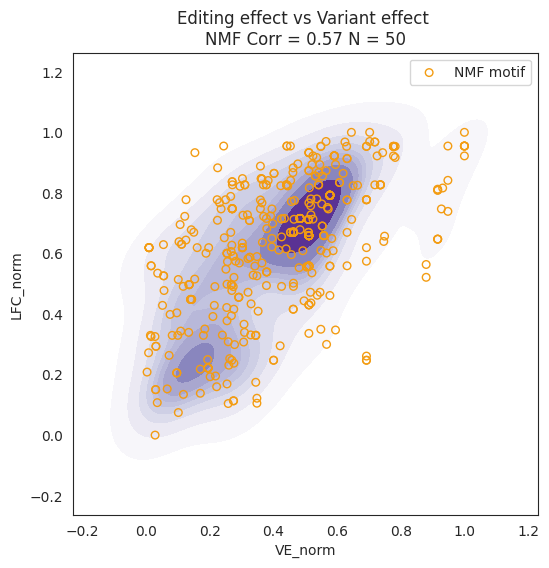

In [11]:
with open('./data/BEresult.pkl','rb') as file:
    data = pickle.load(file)
    x_Raw = data['x_Raw']
    y_Raw = data['y_Raw']
    x_Annotated = data['x_Annotated']
    y_Annotated = data['y_Annotated']

def func(df):return (df - df.min()) / (df.max() - df.min())

x_norm = func(x_Raw)
y_norm = func(y_Raw)

corr_anno = pd.Series(x_Annotated).corr( pd.Series(y_Annotated) )
corr_all  = pd.Series( x_norm ).corr( pd.Series(y_norm) )


print("---- All Motif ----")
print("Pearson =", pearsonr(x_norm, y_norm))

print("\n---- Annoted Motif ----")
print("Pearson =", pearsonr(x_Annotated, y_Annotated))


# ---------------------------
# 3. 绘图
# ---------------------------
import seaborn as sns

plt.figure(figsize=(6,6))

sns.set_style("white")
sns.kdeplot(
    x=x_norm,
    y=y_norm,
    fill=True,
    cmap="Purples",
    thresh=0.05,
    levels=10, bw_adjust=1
)

# 保留annoted_points散点
plt.scatter(
    x_Annotated, 
    y_Annotated, 
    facecolors='none',      # 空心
    edgecolors='#f39c12',  # 边框颜色为黄色
    s=30, 
    label='NMF motif'
)


plt.xlabel('VE_norm')
plt.ylabel('LFC_norm')
plt.title(f'Editing effect vs Variant effect \nNMF Corr = {corr_anno:.2f} N = {50}')
plt.legend()
plt.grid(False)
# plt.savefig('./corr_CBE_eScreen_motiflevel_v2.pdf')
plt.show()